In [10]:
%matplotlib inline
import torch
import time
import torch.nn.functional as F
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')

In [11]:
def init_marginals(num_dims, CUDA, device=None, optimized=False):
    target = {'loc': torch.zeros(num_dims), 
             'log_scale': torch.zeros(num_dims)}
    proposal = {'loc': 8.0 * torch.ones(num_dims),
           'log_scale': torch.log(2.0 * torch.ones(num_dims))}    
    if CUDA:
        with torch.cuda.device(device):
            for key in target.keys():
                target[key] = target[key].cuda()
            for key in proposal.keys():
                proposal[key] = proposal[key].cuda()         
    if optimized:
        for key in target.keys():
            target[key] = torch.nn.Parameter(target[key])
        for key in proposal.keys():
            proposal[key] = torch.nn.Parameter(proposal[key])
            
    return target, proposal

from kernel import Kernel
def init_kernels(num_hiddens, CUDA, device=None):
    fk = Kernel(num_hiddens=num_hiddens)
    bk = Kernel(num_hiddens=num_hiddens)
    if CUDA:
        with torch.cuda.device(device):
            fk.cuda()
            bk.cuda()
    return fk, bk

In [4]:
from torch.distributions.normal import Normal
def loss_1(target, proposal, fk, bk, num_samples):
    """
    this loss function employs the following gradient estimators:
    For phi
    - \nabla_\phi KL (\pi_2(x_2) r_\theta(x_1 | x2) || \pi_1(x1) q_\phi(x_2 | x_1))
    For theta
    - \nabla_\theta KL (\pi_1(x1) q_\phi(x_2 | x_1) || \pi_2(x_2) r_\theta(x_1 | x2))
    so that both of them do not require reparameterization or score function
    """
    p = Normal(target['loc'], target['log_scale'].exp())
    q = Normal(proposal['loc'], proposal['log_scale'].exp())
    x1 = q.sample((num_samples,))
    log_q = q.log_prob(x1)
    x2, log_f, mu_x2, sigma_x2 = fk.forward(x=x1, sampled=True)
    log_p = p.log_prob(x2)
    log_b, mu_x1, sigma_x1 = bk.forward(x=x2, sampled=False, samples_old=x1)
    log_w = (log_p + log_b - log_q - log_f).sum(-1).detach()
    w = F.softmax(log_w, 0)
    ess_f = 1.0 / (w**2).sum(0)
    loss_f = (w * ( - log_f.sum(-1))).sum(0)
    loss_b = - log_b.mean()
    ex_kl = log_w.mean()
    in_kl = (w * log_w).sum()
    return loss_f, loss_b, ess_f, ex_kl, in_kl

def loss_2(target, proposal, fk, bk, num_samples):
    """
    this loss function only targets the inclusive KL divergence:
    - \nabla_\phi KL (\pi_2(x_2) r_\theta(x_1 | x2) || \pi_1(x1) q_\phi(x_2 | x_1))
    """
    p = Normal(target['loc'], target['log_scale'].exp())
    q = Normal(proposal['loc'], proposal['log_scale'].exp())
    x1 = q.sample((num_samples,))
    log_q = q.log_prob(x1)
    x2, log_f, mu_x2, sigma_x2 = fk.forward(x=x1, sampled=True)
    log_p = p.log_prob(x2)
    log_b, mu_x1, sigma_x1 = bk.forward(x=x2, sampled=False, samples_old=x1)
    log_w = (log_p + log_b - log_q - log_f).sum(-1).detach()
    w = F.softmax(log_w, 0)
    ess_f = 1.0 / (w**2).sum(0)
    loss_f = (w * ( - log_f.sum(-1))).sum(0)
    assert log_b.shape == (num_samples, 1), "ERROR"
    loss_b = (w * (log_w) * log_b.squeeze(-1)).sum()
    ex_kl = log_w.mean()
    in_kl = (w * log_w).sum()
    return loss_f, loss_b, ess_f, ex_kl, in_kl


def loss_3(target, proposal, fk, bk, num_samples):
    """
    """
    p = Normal(target['loc'], target['log_scale'].exp())
    q = Normal(proposal['loc'], proposal['log_scale'].exp())
    x1 = q.sample((num_samples,))
    log_q = q.log_prob(x1)
    x2, log_f, mu_x2, sigma_x2 = fk.forward(x=x1, sampled=True)
    log_p = p.log_prob(x2)
    log_b, mu_x1, sigma_x1 = bk.forward(x=x2, sampled=False, samples_old=x1)
    log_w = (log_p + log_b - log_q - log_f).sum(-1).detach()
    w = F.softmax(log_w, 0)
    ess_f = 1.0 / (w**2).sum(0)
    loss_f = (w * ( - log_f.sum(-1))).sum(0)
    assert log_b.shape == (num_samples, 1), "ERROR"
    log_w_t = (log_p + log_b - log_q - log_f.detach()).sum(-1)
    loss_b = (log_w_t.exp() * (log_w_t)).mean()
    ex_kl = log_w.mean()
    in_kl = (w * log_w).sum()
    return loss_f, loss_b, ess_f, ex_kl, in_kl

def loss_4(target, proposal, fk, bk, num_samples):
    """
    """
    p = Normal(target['loc'], target['log_scale'].exp())
    q = Normal(proposal['loc'], proposal['log_scale'].exp())
    x1 = q.sample((num_samples,))
    log_q = q.log_prob(x1)
    x2, log_f, mu_x2, sigma_x2 = fk.forward(x=x1, sampled=True)
    log_p = p.log_prob(x2)
    log_b, mu_x1, sigma_x1 = bk.forward(x=x2, sampled=False, samples_old=x1)
    log_w = (log_p + log_b - log_q - log_f).sum(-1).detach()
    w = F.softmax(log_w, 0)
    ess_f = 1.0 / (w**2).sum(0)
    loss_f = (w * ( - log_f.sum(-1))).sum(0)
    loss_b = (w * (- log_b.sum(-1))).sum(0)
    ex_kl = log_w.mean()
    in_kl = (w * log_w).sum()
    return loss_f, loss_b, ess_f, ex_kl, in_kl

import pandas as pd
def train(grad_steps, loss, optimizer, target, proposal, fk, bk, num_samples):
    time_start = time.time()
    output = pd.DataFrame(index=range(grad_steps), columns=['loss_f', 'loss_b', 'ess_f', 'ex_kl', 'in_kl'])
    for n in range(grad_steps):
        loss_f, loss_b, ess_f, ex_kl, in_kl = loss(target=target, proposal=proposal, fk=fk, bk=bk, num_samples=num_samples)
        loss_f.backward(retain_graph=True)
        loss_b.backward()
        optimizer.step()
        optimizer.zero_grad()

        output['loss_f'][n] = loss_f.detach().cpu().data.numpy()
        output['loss_b'][n] = loss_b.detach().cpu().data.numpy()
        output['ess_f'][n] = ess_f.cpu().data.numpy()
        output['ex_kl'][n] = ex_kl.cpu().data.numpy()
        output['in_kl'][n] = in_kl.cpu().data.numpy()  
    time_end = time.time()
    print('%d gradient steps in %ds' % (grad_steps, time_end - time_start))
    return output

import numpy as np
import matplotlib.pyplot as plt
def plot_convergence(output, obj, num_samples, grad_steps):
    fs = 8
    fig = plt.figure(figsize=(fs*2.5,fs))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(output['ex_kl'], label=r'$\mathrm{KL} (\pi_1(x_1) \: q_\phi (x_2 | x_1) \: || \: \pi_2(x_2) \: r_\theta(x_1 | x_2))$')
    ax1.plot(output['in_kl'], label=r'$\mathrm{KL} (\pi_2(x_2) \: r_\theta(x_1 | x_2) \: || \: \pi_1(x_1) \: q_\phi (x_2 | x_1))$')
    ax1.plot(np.zeros(grad_steps), label='zero constant')
    ax1.set_ylim(-10, 10)
    ax1.set_xlabel('Gradient Steps')
    ax1.legend(fontsize=16)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(output['ess_f'], label='ESS with %d samples' % num_samples)
    ax2.legend(fontsize=16)
    ax2.set_xlabel('Gradient Steps')
    plt.savefig('results-loss%d-%dsamples-%dsteps.png' % (obj, num_samples, grad_steps))

In [5]:
def train_and_plot(obj, num_dims, num_hiddens, num_samples, grad_steps, CUDA, device):
    print("Training with Loss %d, Marginal Dim=%d, Sample Size=%d, Gradient Steps=%d" % (obj, num_dims, num_samples, grad_steps))
    target, proposal = init_marginals(num_dims=num_dims, CUDA=CUDA, device=device, optimized=False)
    fk, bk = init_kernels(num_hiddens=num_hiddens, CUDA=CUDA, device=device)
    optimizer = torch.optim.Adam(list(fk.parameters())+list(bk.parameters()), lr=1e-3, betas=(0.9, 0.99))
    
    if obj == 1:
        output = train(grad_steps=grad_steps, 
                       loss=loss_1, 
                       optimizer=optimizer, 
                       target=target, 
                       proposal=proposal, 
                       fk=fk,
                       bk=bk,
                       num_samples=num_samples)
    elif obj == 2:
        output = train(grad_steps=grad_steps, 
                       loss=loss_2, 
                       optimizer=optimizer, 
                       target=target, 
                       proposal=proposal,
                       fk=fk,
                       bk=bk,
                       num_samples=num_samples)
    elif obj == 3:
        output = train(grad_steps=grad_steps, 
                       loss=loss_3, 
                       optimizer=optimizer, 
                       target=target, 
                       proposal=proposal, 
                       fk=fk,
                       bk=bk,
                       num_samples=num_samples)
    elif obj == 4:
        output = train(grad_steps=grad_steps, 
                   loss=loss_4, 
                   optimizer=optimizer, 
                   target=target, 
                   proposal=proposal, 
                   fk=fk,
                   bk=bk,
                   num_samples=num_samples)      
    plot_convergence(output=output, obj=obj, num_samples=num_samples, grad_steps=grad_steps)

Training with Loss 1, Marginal Dim=1, Sample Size=100, Gradient Steps=2000
2000 gradient steps in 16s


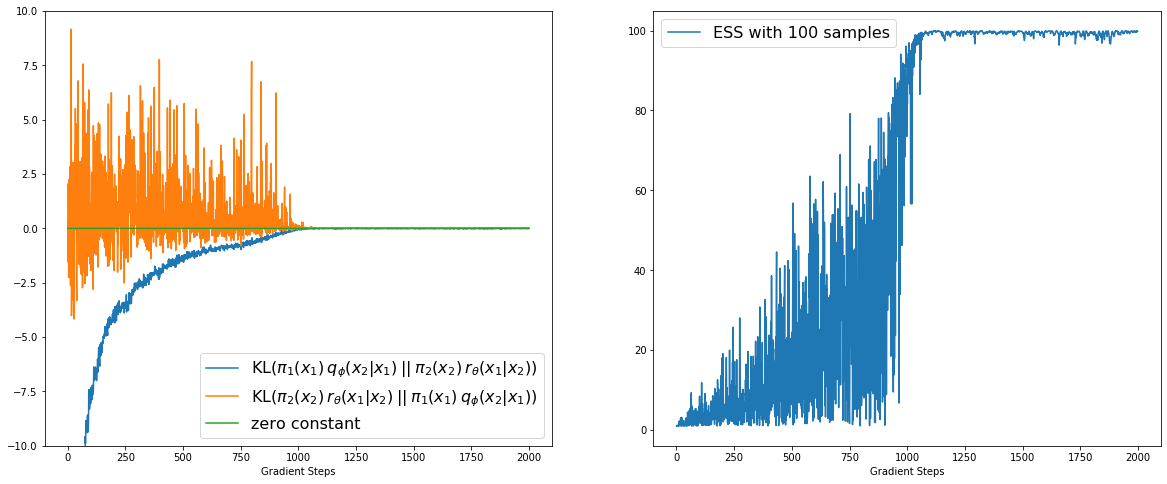

In [6]:
NUM_DIMS = 1
NUM_HIDDENS = 8
GRAD_STEPS = 2000
NUM_SAMPLES = 100

train_and_plot(obj=1, 
               num_dims=NUM_DIMS, 
               num_hiddens=NUM_HIDDENS, 
               num_samples=NUM_SAMPLES, 
               grad_steps=GRAD_STEPS, 
               CUDA=CUDA, 
               device=DEVICE)

Training with Loss 2, Marginal Dim=1, Sample Size=100, Gradient Steps=4000
4000 gradient steps in 34s


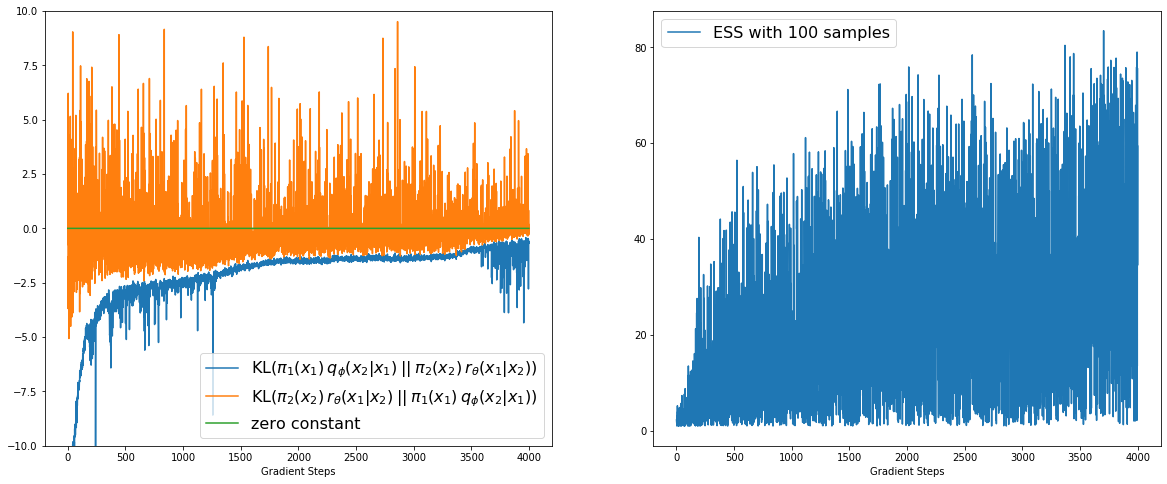

In [9]:
train_and_plot(obj=2, 
               num_dims=NUM_DIMS, 
               num_hiddens=NUM_HIDDENS, 
               num_samples=NUM_SAMPLES, 
               grad_steps=4000, 
               CUDA=CUDA, 
               device=DEVICE)